In [22]:
%matplotlib inline
import os
from cca_zoo.models import CCA
from cca_zoo.data import generate_covariance_data
from cca_zoo.models import rCCA
from cca_zoo.model_selection import GridSearchCV
from cca_zoo.deepmodels import architectures
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
os.chdir('../raw_data')

#### Functions to load and or write to pickle files

In [23]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [24]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_spec_embedding.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',
 'spec2vec_model_GNPS_15_12_2021.model.wv.vectors.npy',
 'spectra_unique_GNPS_15_12_2021.pickle']

In [10]:
#load spec2vec embeddings
path_spec2vec = './spec2vec_embeddings_unique_GNPS_15_12_2021.pickle'
spec2vec = Files(path_spec2vec).load_pickle()#[:10000]
len(spec2vec)


20889

In [4]:
#load uniq ms2ds
path = './ms2ds_embeddings_unique_GNPS_15_12_2021.pickle'
ms_uniq = Files(path).load_pickle()
len(ms_uniq)

20889

In [71]:
#load ms2ds embeddings
path = './GNPS_15_12_2021_ms2ds_embeddings.pickle'
ms2ds = Files(path).load_pickle()


ms2ds.tail()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
CCMSLIB00000579925,5.444295,0.000000,0.0,0.000000,0.0,25.566275,0.000000,0.000000,12.433298,21.435843,...,0.0,14.670666,9.170443,0.000000,29.769424,3.146680,0.000000,1.279594,17.032347,15.988544
CCMSLIB00004683390,0.000000,0.000000,0.0,10.573889,0.0,3.625986,9.882024,9.222461,0.000000,0.000000,...,0.0,0.000000,5.694060,12.026726,0.000000,16.625841,0.000000,0.000000,0.000000,0.000000
CCMSLIB00004683403,0.000000,8.779794,0.0,10.539032,0.0,0.000000,22.068830,0.000000,0.000000,0.000000,...,0.0,0.000000,2.786316,19.453104,0.000000,14.607656,0.000000,0.000000,0.000000,0.000000
CCMSLIB00004683409,0.000000,6.782707,0.0,7.057279,0.0,0.000000,21.694965,0.000000,0.000000,0.000000,...,0.0,0.000000,6.498924,18.673382,0.000000,18.044722,2.148497,0.000000,0.000000,0.000000
CCMSLIB00004683411,0.000000,16.076180,0.0,1.880418,0.0,0.000000,29.188948,0.000000,0.000000,0.000000,...,0.0,0.000000,4.826595,22.101501,0.000000,19.224155,14.056287,0.000000,0.000000,0.000000


In [69]:

#load mol2vec embeddings
path_mol2vec = './mol2vec_embedding.pickle'
mol2vec = Files(path_mol2vec).load_pickle()[:302514]# since mol2vec we have upto 302514
len(mol2vec)

302514

In [72]:
#split the dataset
x_train, x_test, y_train, y_test = \
train_test_split(ms2ds, mol2vec, test_size=0.2, random_state=42)

In [73]:
#init CCA
latent_dims=200
linear_cca = CCA(latent_dims=latent_dims)

In [74]:
#fit and transform
train_z1, train_z2 = linear_cca.fit_transform([x_train, y_train])

In [75]:
# extract correlation between the views
train_cor=linear_cca.score([x_train, y_train])
len(train_cor)

200

In [76]:
# transform the test dataset
test_z1, test_z2 = linear_cca.transform([x_test,y_test])
test_cor = linear_cca.score([x_test, y_test])

In [77]:
# create a train pd for plotting
dims = [i for i in range(1,latent_dims+1)] # adding 1 to start from 1
dims
train_cor_df = pd.DataFrame(list(zip(dims,train_cor)),\
                      columns=['latent_dim','cor']) 
train_cor_df.head()

,latent_dim,cor
0,1,0.806967
1,2,0.351344
2,3,0.336317
3,4,0.288323
4,5,0.203956


In [78]:
# create a test pd for plotting
dims = [i for i in range(1,latent_dims+1)]

test_cor_df = pd.DataFrame(list(zip(dims,test_cor)),\
                      columns=['latent_dim','cor']) 
test_cor_df.head()

,latent_dim,cor
0,1,0.802216
1,2,0.336774
2,3,0.331493
3,4,0.263769
4,5,0.193356


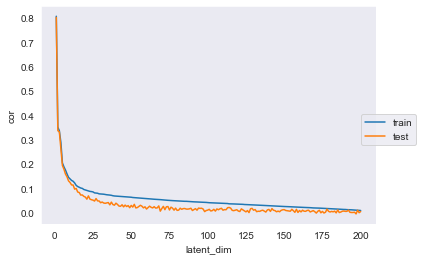

In [80]:
fig, ax = plt.subplots()
sns.set_style('dark')
dfs = [train_cor_df,test_cor_df]
for df in dfs:
    sns.lineplot(data = df, x='latent_dim',y='cor',ax=ax)
fig.legend(labels=['train', 'test'], loc='center right')
plt.show()


In [ ]:
#Think of importing plot_validation 